https://heartbeat.comet.ml/how-to-build-a-text-classification-model-using-huggingface-transformers-and-comet-4d40236e8f84



In [1]:
import pandas as pd
import numpy as np
from transformers.integrations import TensorBoardCallback
from torch.utils.tensorboard import SummaryWriter

In [3]:
!pip install huggingface

  Using cached huggingface-0.0.1-py3-none-any.whl (2.5 kB)


In [4]:
!pip install huggingface transformers

In [2]:
df = pd.read_csv('filtered_data.csv')
df.info()
df = df.drop(['withheld'], axis = 1)

c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,1,10,11,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944498 entries, 0 to 944497
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   user_id          944498 non-null  object
 1   tweet_id         944484 non-null  object
 2   tweet_text       944484 non-null  object
 3   place_id         924718 non-null  object
 4   name             924718 non-null  object
 5   full_name        924718 non-null  object
 6   country          924718 non-null  object
 7   country_code     924718 non-null  object
 8   type             924718 non-null  object
 9   username         924718 non-null  object
 10  description      791620 non-null  object
 11  user_name_field  859163 non-null  object
 12  location         801094 non-null  object
 13  withheld         51 non-null      object
 14  clean_text       857531 non-null  object
dtypes: object(15)
memory usage: 108.1+ MB


In [3]:
country_list = ['United States', 'United Kingdom', 'Canada', 'India', 'Australia', 'Nigeria']
df= df[df['country'].isin(country_list)]
df['country'].value_counts()
df.head()

,user_id,tweet_id,tweet_text,place_id,name,full_name,country,country_code,type,username,description,user_name_field,location,clean_text
0,1051074201082388480,1637850668214960128,@Gajendr70729189 @amitsharma2704 @1shankarshar...,5f55bb82cf16ac81,Bengaluru South,"Bengaluru South, India",India,IN,city,Pavanasoonu,Global SAP Tech. #Jyotishkatti. Spiritual cou...,Pavanasoonu,"Bengaluru, India",Including my SAP technology business. Thank ...
1,1051074201082388480,1637818231863001090,@JatinPandyaVBNJ @1shankarsharma Indeed. Nadi...,5f55bb82cf16ac81,Bengaluru South,"Bengaluru South, India",India,IN,city,Pavanasoonu,Global SAP Tech. #Jyotishkatti. Spiritual cou...,Pavanasoonu,"Bengaluru, India",Indeed. Nadi Jyotish has excellent rules. N...
2,1051074201082388480,1637737394911969280,@1shankarsharma Namaste. How many years have ...,5f55bb82cf16ac81,Bengaluru South,"Bengaluru South, India",India,IN,city,Pavanasoonu,Global SAP Tech. #Jyotishkatti. Spiritual cou...,Pavanasoonu,"Bengaluru, India",Namaste. How many years have you spent learn...
3,1051074201082388480,1637733079002537986,An excellent example of jumping into conclusio...,5f55bb82cf16ac81,Bengaluru South,"Bengaluru South, India",India,IN,city,Pavanasoonu,Global SAP Tech. #Jyotishkatti. Spiritual cou...,Pavanasoonu,"Bengaluru, India",An excellent example of jumping into conclusio...
4,1051074201082388480,1637660117624836096,The want for financial security must be balanc...,5f55bb82cf16ac81,Bengaluru South,"Bengaluru South, India",India,IN,city,Pavanasoonu,Global SAP Tech. #Jyotishkatti. Spiritual cou...,Pavanasoonu,"Bengaluru, India",The want for financial security must be balanc...


In [4]:
filtered_df = df[['user_id', 'tweet_id', 'tweet_text', 'country']]
filtered_df.head()
updated_df = filtered_df.astype({'user_id':np.int64, 'tweet_id': np.int64, 'tweet_text': str, 'country':str})
updated_df.to_csv('updated_df.csv')

id2label = {0: "United States", 1: "United Kingdom", 2: "Canada", 3: "Australia", 4: "India", 5: "Nigeria"}
label2id = {"United States": 0, "United Kingdom": 1, "Canada": 2, "Australia": 3, "India": 4, "Nigeria": 5}

In [5]:
sample_df = updated_df.sample(5000, random_state = 1)
sample_df.head()
sample_df['country'] = sample_df['country'].apply(lambda x: label2id[x])
sample_df.head()

,user_id,tweet_id,tweet_text,country
810865,490104241,1637289107557879808,My aunt married a white man with the last name...,0
737537,2486046872,1635484083256979456,@GovRonDeSantis It shouldn't include theologic...,0
635983,1374446305146138626,1633236299640365057,"I had my best day ever at work, today!!!!! Fou...",0
488230,100339412,1637856072521363456,@DawiLDanger My earbuds are from Big Lots (a c...,0
659364,1488755185,1637782944667320320,@CraigAFountain Same! Thanks for having me!!!,0


<AxesSubplot:xlabel='country'>

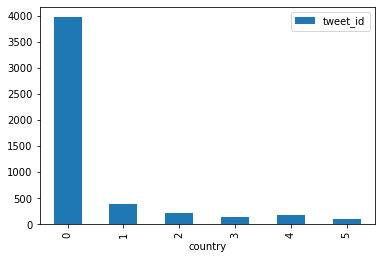

In [6]:
sample_df.groupby('country').agg('count').reset_index().plot(x='country', y = 'tweet_id', kind = 'bar')

In [7]:
!pip install datasets

In [8]:
from datasets import Dataset

In [9]:
train, validate, test = np.split(sample_df.sample(frac=1), [int(.6*len(sample_df)), int(.8*len(sample_df))])

<AxesSubplot:xlabel='country'>

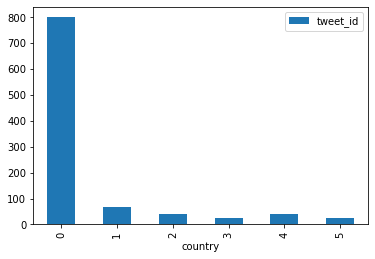

In [10]:
validate.groupby('country').agg('count').reset_index().plot(x='country', y = 'tweet_id', kind = 'bar')

In [11]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index = False)
validate.to_csv('validate.csv', index = False)

In [12]:
ds_train = Dataset.from_csv('train.csv')
ds_val = Dataset.from_csv('validate.csv')
ds_test = Dataset.from_csv('test.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to C:/Users/Steve Toner/.cache/huggingface/datasets/csv/default-dfa73d6354048e42/0.0.0. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to C:/Users/Steve Toner/.cache/huggingface/datasets/csv/default-20f6f9e116548098/0.0.0. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to C:/Users/Steve Toner/.cache/huggingface/datasets/csv/default-d5823e45ad9da5bc/0.0.0. Subsequent calls will reuse this data.


In [13]:
ds = {"train": ds_train, "validation": ds_val, "test": ds_test}

In [14]:
ds_train[0]

{'user_id': 1020470136699056128,
 'tweet_id': 1632149142569877504,
 'tweet_text': "It's a hockey night in South Florida... #timetohunt https://t.co/f0Ep6tr130",
 'country': 0}

In [15]:
ds_train

Dataset({
    features: ['user_id', 'tweet_id', 'tweet_text', 'country'],
    num_rows: 3000
})

In [16]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained("Twitter/twhin-bert-base", num_labels=6, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at Twitter/twhin-bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Twitter/twhin-bert-ba

In [17]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, DataCollatorWithPadding
tokenizer = AutoTokenizer.from_pretrained('Twitter/twhin-bert-base')

In [18]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Using old preprocessing function for now, baseline results
def preprocess_function(examples):
    label = examples["country"] 
    # examples['tweet_text'].apply(preprocess)
    # examples = tokenizer(preprocess(examples["tweet_text"]), truncation=True, padding="max_length", max_length=256, return_tensors='pt')
    examples = tokenizer(examples["tweet_text"], truncation=True, padding="max_length", max_length=256, return_tensors='pt')
    for key in examples:
        examples[key] = examples[key].squeeze(0)
    examples["label"] = label
    return examples

for split in ds:
    ds[split] = ds[split].map(preprocess_function, remove_columns=['user_id', 'tweet_id', 'tweet_text', 'country'])
    ds[split].set_format('pt')

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [19]:
example = next(iter(ds['test']))

In [20]:
tokenizer.decode(example['input_ids'])

'<s> The Atlanta Hawks, have no Heart https://t.co/p2LKgLVmnz</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [21]:
ds['train']["label"][:10]

tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 2])

In [ ]:
!pip install evaluate

In [22]:
import evaluate

accuracy = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

In [26]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": accuracy.compute(predictions=predictions, references=labels), "f1":f1_metric.compute(predictions=predictions, references=labels, average="weighted")}

In [27]:
import torch
class TwitterTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = torch.nn.functional.cross_entropy(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [28]:
from transformers import TrainingArguments
from transformers import Trainer


tb = TensorBoardCallback()

In [29]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = TwitterTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics,
    callbacks = [tb]
)


You are adding a <class 'transformers.integrations.TensorBoardCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
TensorBoardCallback


In [30]:

trainer.train()

C:\Users\Steve Toner\AppData\Roaming\Python\Python38\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/376 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
trainer.evaluate()

Trainer is attempting to log a value of "{'accuracy': 0.829}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.8021886040993591}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.7434858679771423,
 'eval_accuracy': {'accuracy': 0.829},
 'eval_f1': {'f1': 0.8021886040993591},
 'eval_runtime': 17.3352,
 'eval_samples_per_second': 57.686,
 'eval_steps_per_second': 3.634,
 'epoch': 2.0}

In [ ]:
predictions = trainer.predict(ds['test'])

In [ ]:
predictions

PredictionOutput(predictions=array([[-1.1753128e-01, -1.6444532e-02, -5.3166467e-01, -3.4069392e-01,
         2.9098943e-01,  8.0153126e-01],
       [-6.2814379e-01, -8.7985867e-01, -3.4760940e-01,  4.1945424e-02,
         2.1285038e+00, -1.0165071e+00],
       [ 5.3725195e+00,  5.8511466e-02, -1.9380964e-01, -8.1769091e-01,
        -2.7476633e+00, -1.7396835e+00],
       ...,
       [-2.5696127e+00,  1.2272263e+00, -3.3492857e-01,  3.3991376e-01,
         2.7463822e+00, -7.9077470e-01],
       [ 5.1196032e+00,  4.8865637e-01,  2.2010575e-01, -9.5231241e-01,
        -3.2083671e+00, -1.4377913e+00],
       [ 5.5168905e+00,  1.3789328e-02,  4.0565976e-03, -1.0782397e+00,
        -2.8317249e+00, -1.6308876e+00]], dtype=float32), label_ids=array([0, 4, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1,
       5, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 5, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0

In [ ]:
predictions[0]

array([[-1.1753128e-01, -1.6444532e-02, -5.3166467e-01, -3.4069392e-01,
         2.9098943e-01,  8.0153126e-01],
       [-6.2814379e-01, -8.7985867e-01, -3.4760940e-01,  4.1945424e-02,
         2.1285038e+00, -1.0165071e+00],
       [ 5.3725195e+00,  5.8511466e-02, -1.9380964e-01, -8.1769091e-01,
        -2.7476633e+00, -1.7396835e+00],
       ...,
       [-2.5696127e+00,  1.2272263e+00, -3.3492857e-01,  3.3991376e-01,
         2.7463822e+00, -7.9077470e-01],
       [ 5.1196032e+00,  4.8865637e-01,  2.2010575e-01, -9.5231241e-01,
        -3.2083671e+00, -1.4377913e+00],
       [ 5.5168905e+00,  1.3789328e-02,  4.0565976e-03, -1.0782397e+00,
        -2.8317249e+00, -1.6308876e+00]], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
predictions_array = np.argmax(predictions[0], axis = 1)

In [ ]:
predictions_array

array([5, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       5, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,
       0, 0, 0, 0, 1, 0, 0, 0, 4, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,

In [ ]:
labels_array = predictions[1]
labels_array

array([0, 4, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1,
       5, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 5, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 3, 2, 0, 0, 0, 0, 0, 0, 2, 2, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4,
       0, 0, 0, 0, 3, 0, 0, 0, 4, 0, 3, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1,
       0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 5, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 4, 0, 1, 0, 1, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 4, 0,

In [ ]:
confusion_matrix(labels_array, predictions_array)

array([[785,  11,   2,   0,   3,   3],
       [ 45,  30,   2,   1,   1,   0],
       [ 31,   0,   7,   1,   0,   0],
       [ 16,   4,   2,   2,   1,   1],
       [ 11,   2,   0,   2,  23,   0],
       [  5,   0,   0,   0,   2,   7]])